# Gaussian mixture model with expectation maximization algorithm

GMM with EM.

This notebook implements the following:

1) Function that avoids computing inverse of matrix when computing $y = A^{-1}x$ by solving system of linear equations.

2) Log sum trick to avoid underflow when multiplying small numbers.

3) pdf of the Multivariate normal distribution

4) E-step function of the EM algorithm

5) M-step function of the EM algorithm

6) Variational lower bound function

7) GMM function

8) Training function for GMM

9) Scatter plot of clusters (Plot at the bottom of this notebook shows 8 clusters from a dataset of 100 points)

# Imports

In [0]:
import sys
import numpy as np
from numpy.linalg import det, solve
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Variables info

N: number of data (rows)

d: dimension of data

X: (N x d), data points

C: int, number of clusters

Computed from E-step:

gamma: (N x C), distribution q(T), probabilities of clusters for objects

Initial values are also subsequently computed & updated from M-step:

pi: (C), mixture component weights, initial weights of T (latent variable), sum to 1, t=1, 2 or 3.
mu: (C x d), mixture component means

sigma: (C x d x d), # mixture component covariance matrices   

# Generate random data.

[[0.8385007  0.42450664]
 [0.16693686 0.46690006]
 [0.94215602 0.54735266]
 [0.10595023 0.36211707]
 [0.96505428 0.31135285]]
(100, 2)


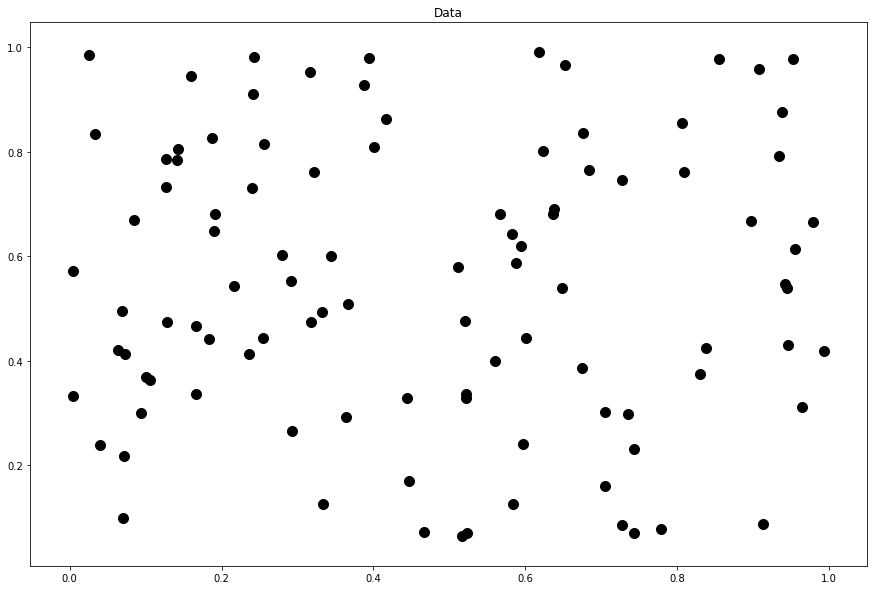

In [0]:
N = 100
d = 2

X = np.random.rand(N,d)

print(X[:5])
print(X.shape)

fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.set_title('Data')
ax.scatter(X[:, 0], X[:, 1], c='black', s=100)
#plt.axis('equal')
plt.show() 

# Generate initial values

In [0]:
epsilon = 1e-10 # Use in stopping criterion as well as in preventing numerical errors.

C = 7

def rand_input(C, d):  
  # https://stackoverflow.com/questions/18659858/generating-a-list-of-random-numbers-summing-to-1
  pi0 = np.random.dirichlet(np.ones(C),size=1)[0] # Generating a list of random numbers, summing to 1
  mu0 = np.random.rand(C,d)
  sigma0 = np.random.rand(C,d,d)
  return pi0, mu0, sigma0

pi0, mu0, sigma0 = rand_input(C, d)

print(pi0)
print(pi0.shape)
print(mu0)
print(mu0.shape)
print(sigma0)
print(sigma0.shape)

[0.15505394 0.25923615 0.02319332 0.013419   0.35227539 0.03302238
 0.16379982]
(7,)
[[0.68973301 0.45285438]
 [0.37717468 0.0774671 ]
 [0.08040437 0.72996964]
 [0.24627139 0.07737679]
 [0.85525475 0.54874499]
 [0.52529973 0.60750795]
 [0.63066747 0.65055031]]
(7, 2)
[[[0.04086514 0.69862527]
  [0.55383492 0.72568871]]

 [[0.06219694 0.31713604]
  [0.0782174  0.20277984]]

 [[0.87933668 0.78420385]
  [0.68765529 0.81669227]]

 [[0.67728262 0.69059881]
  [0.23892581 0.25633766]]

 [[0.22737808 0.93778513]
  [0.70590234 0.59755095]]

 [[0.5798406  0.36390048]
  [0.25105302 0.91514072]]

 [[0.94324841 0.05541207]
  [0.97075636 0.50341048]]]
(7, 2, 2)


# Avoid computing inverse of matrix when computing y=(A_inverse)x.

In [0]:
# Function which avoids computing inverse of matrix when computing y=(A_inverse)x by solving linear equations.
# Use in E-step.

def _A_inverse_times_X(A, X):
  # A is nxn
  # X is rxn
 
  Y = []
  for row_data in X:
    Y_new = np.linalg.solve(A, row_data)
    Y.append(Y_new)

  Y = np.asarray(Y)
  assert Y.shape == X.shape, "Output shape must be equal to shape of X."

  return Y

# Multivariate normal (Gaussian) distribution

$MVN = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})\right)$

Computes pdf of Multivariate normal (Gaussian) distribution.

In [0]:
# Alternatively, one could also use multivariate_normal.pdf from scipy.stats 
# instead of this function

def __mvg(cov, X, mean):
  diff = X - mean
  Y = _A_inverse_times_X(cov, diff)
  pow_term = -0.5 * np.matmul(Y, diff.T)
  e_term = np.exp(pow_term)

  const_term = (2*np.pi)**(X.shape[1])
  det_term = np.linalg.det(cov)
  deno_term = np.sqrt(np.multiply(const_term, det_term))

  P = np.divide(e_term, deno_term)
  
  return P.diagonal() # returns the pdf, shape=(num_X,)

In [0]:
# Returns pdf for multiple components.

def _mvg(cov, X, mean):
  P = []
  for i, r in enumerate(mean):   
    P.append(__mvg(cov[i], X, mean[i]))
  
  return P # shape=(C, num_X)

# Log sum trick

In [0]:
# log sum trick to prevent underflow in E-step.
# https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
# https://web.archive.org/web/20150502150148/http://machineintelligence.tumblr.com/post/4998477107/the-log-sum-exp-trick
# https://www.quora.com/Why-is-e-log_-e-x-equal-to-x

def exp_normalize(x):
  b = x.max()
  y = np.exp(x - b)

  return y / y.sum()

# E-step

Multiply the initial weight of the class with the multivariate guassian pdf of each data from the class.

In [0]:
def E_step(X, pi, mu, sigma):
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T) 
    gamma = np.mat(np.zeros((N, C)))

    prob = _mvg(sigma, X, mu) # pdf of data X in each class
    prob = np.mat(prob)

    for c in range(C):       
        # Instead of multiplying probabilities directly which could result in underflow,
        # we'll work in log scale.
        # pi[c] = P(T=c), prob[c, :] = P(X|T=c)
        #gamma[:, c] = np.multiply(pi[c], prob[c, :].T)        
        gamma[:, c] = np.log(pi[c] + epsilon) + np.log(prob[c, :].T + epsilon)
        
    for i in range(N):
        # Instead of summing the denominator, we'll use the log sum trick coded in exp_normalize function.
        gamma[i, :] = exp_normalize(gamma[i, :])

    return gamma # Q(T) = P(T|X,theta), weights of each model (class) for each data in X.

# M-Step

Compute the following:

[Equations from wiki](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm#E_step)

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/0e0327c8676ae66ec651b422a19f5ea532913c7a)

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/45f3e73f50d396aadc98182709eee0c0d513aa6b)

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/a92651be432155520db19dc0b4da807039d96eb0)

In [0]:
def M_step(X, gamma):
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    mu = np.zeros((C, d))
    sigma = []
    pi = np.zeros(C)

    # for each model in C
    for c in range(C):
        # sum of all Q(t) of model c
        sum_Q_t = np.sum(gamma[:, c])

        # mean of model c
        mu[c, :] = np.sum(np.multiply(X, gamma[:, c]), axis=0) / sum_Q_t
                  
        # cov of model c
        diff = X - mu[c]
        sigma.append(diff.T @ np.multiply(diff, gamma[:, c]) / sum_Q_t)

        # weight of model c
        pi[c] = sum_Q_t / N

    return pi, mu, np.asarray(sigma)

# Variational lower bound

Computes the scalar output of the following:

$$\sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i =c) (\log \pi_c + \log(MVN)) - \sum_{i=1}^{N} \sum_{c=1}^{K} q(t_i =c) \log q(t_i =c)$$

In [0]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    VLB = 0.0
    for c in range(C):      
      mu_c = np.expand_dims(mu[c,:], axis=0)    
      sigma_c = np.expand_dims(sigma[c,:], axis=0)     
      gamma_c = gamma[:,c]
      
      mvg = np.asarray(_mvg(sigma_c, X, mu_c)) # 1xc
      sum = np.log(pi[c] + epsilon) + np.log(mvg + epsilon) # 1xc, + 1e-30 to prevent log(0)
      prod = np.multiply(gamma_c, sum.T) # transpose sum for element wise multiplication
      prod2 = np.multiply(gamma_c, np.log(gamma_c + epsilon)) # element wise multiplication, + 1e-30 to prevent log(0)
      VLB += (prod - prod2)

    VLB = np.sum(VLB, axis=0) # sum all values for all rows

    return VLB

# GMM

Find the best parameters by optimizing with the following criterion:

Stopping threshold: ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{threshold}$)

In [0]:
def GMM(X, C, d, threshold=epsilon, max_iter=1000, trial=500):
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_VLB = None
    best_pi = None
    best_mu = None
    best_sigma = None

    for rs in range(trial):
        try:
            pi, mu, sigma = rand_input(C, d) # Try random initial values
            curr_LVB, prev_LVB = 0.0, 0.0 
            iter = 0                       
            while iter < max_iter:        
                #print('iter, rs', iter, rs)        

                prev_LVB = curr_LVB

                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                curr_LVB = compute_vlb(X, pi, mu, sigma, gamma)
                
                #print('prev_LVB', prev_LVB)
                #print('curr_LVB', curr_LVB)
                               
                # LVB is the variation lower bound function. It must NOT be decreasing.
                # We are trying to maximize LVB so that the gap between LVB & GMM is minimized.                             
                if prev_LVB != 0.0 and curr_LVB < prev_LVB:
                    print('VLB ERROR EXIT!: curr_LVB < prev_LVB')
                    sys.exit(1)

                # If numerical error in LVB, goto next trial.
                if np.isnan(curr_LVB) == True:
                    break
                
                if prev_LVB != 0.0 and abs((curr_LVB - prev_LVB) / (prev_LVB)) <= threshold:
                    if best_VLB == None or curr_LVB > np.float32(best_VLB):
                        best_VLB = curr_LVB
                        best_pi = pi
                        best_mu = mu
                        best_sigma = sigma
                    break # end while loop, goto for loop    

                iter += 1

        except np.linalg.LinAlgError:
            print("Singular matrix not allowed.")
            pass

    return best_VLB, best_pi, best_mu, best_sigma

# Train

In [0]:
# Train
# If numerical errors occured, run a couple of more times.

best_VLB, best_pi, best_mu, best_sigma = GMM(X, C, d)
print('best_VLB', best_VLB)
print('best_pi', best_pi)
print('best_mu', best_mu)
print('best_sigma', best_sigma)

# Use the best values to do 1 more E-step to get gamma.
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = np.ravel(gamma.argmax(axis=1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


best_VLB [[27.69766358]]
best_pi [0.15176426 0.11403155 0.25836147 0.16461504 0.06850892 0.12151512
 0.12120364]
best_mu [[0.66418722 0.719562  ]
 [0.94669274 0.6414436 ]
 [0.22726852 0.58472473]
 [0.6293771  0.31757752]
 [0.6687598  0.0752092 ]
 [0.07339611 0.35628135]
 [0.35334335 0.90019362]]
best_sigma [[[ 1.18317641e-02  1.15760869e-02]
  [ 1.15760869e-02  1.58472564e-02]]

 [[ 6.56751911e-04 -2.41174345e-03]
  [-2.41174345e-03  4.04580674e-02]]

 [[ 9.91385901e-03 -1.19790503e-02]
  [-1.19790503e-02  4.16119934e-02]]

 [[ 1.73175768e-02  2.48650621e-03]
  [ 2.48650621e-03  1.25128016e-02]]

 [[ 2.37369480e-02  9.13551410e-04]
  [ 9.13551410e-04  6.25294334e-05]]

 [[ 1.66308413e-03 -1.14467725e-04]
  [-1.14467725e-04  1.63920030e-02]]

 [[ 2.88347390e-02  5.55744016e-03]
  [ 5.55744016e-03  5.96810781e-03]]]


# Scatter plot

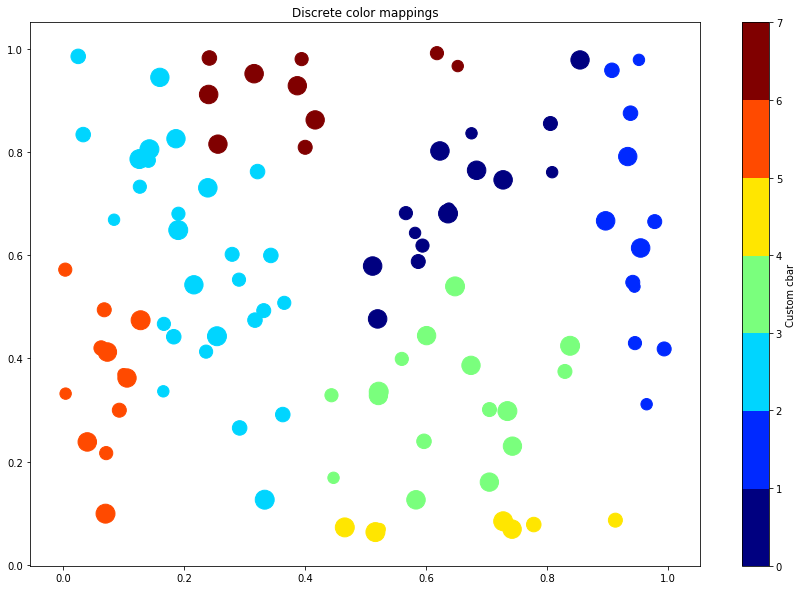

In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

'''
# Generate colors for each class.
# only works for max of 4 classes.
def gen_col(C):
  colors =[]
  for c in range(C):
    colors.append(np.random.randint(0, 255, C) / 255)
  print(colors)  
  return colors 

colors = gen_col(C)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=matplotlib.colors.ListedColormap(colors), s=30)
plt.axis('equal')
plt.show()
'''

# https://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels

N = C # Number of labels

# setup the plot
fig, ax = plt.subplots(1,1, figsize=(15,10))
# define the data
x = X[:, 0]
y = X[:, 1]
tag = labels

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x, y, c=tag, s=np.random.randint(100,500,N), cmap=cmap, norm=norm)

# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Custom cbar')
ax.set_title('Discrete color mappings')
plt.show()